In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from joblib import dump, load
import pickle
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from ctgan import CTGAN

### Data Preprocessing

Focuse on service == http, drop columns which have the same values in all rows ('protocol_type', 'land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds', 'is_host_login', 'is_guest_login'). drop columns "index" and "flag" after dummies this column. Swap class from values "normaly" & "anomaly" to 1 & 0. 

In [78]:
df = pd.read_csv("..\\data\\IPS\\Train_data.csv")
df = df[df['service'].str.contains('http')]
df = df.drop(columns=["service"])
df = df.reset_index()
df = df.drop(columns=["protocol_type"])
df = df.drop(columns=["index"])

In [79]:
colum = df['flag'].value_counts()
print(colum)
print(df)

flag
SF      7104
REJ      556
S0       351
S1        42
RSTR      25
RSTO      16
S2        15
S3         6
SH         1
OTH        1
Name: count, dtype: int64
      duration flag  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0            0   SF        232       8153     0               0       0    0   
1            0   SF        199        420     0               0       0    0   
2            0   SF        287       2251     0               0       0    0   
3            0   SF        300      13788     0               0       0    0   
4            0   SF        233        616     0               0       0    0   
...        ...  ...        ...        ...   ...             ...     ...  ...   
8112         0   SF       2499       2737     0               0       0    0   
8113         0   SF        193       2408     0               0       0    0   
8114         0   SF        252       6160     0               0       0    0   
8115         0   SF        293       24

In [80]:
#split column flag
df_dumm = pd.get_dummies(df["flag"], prefix="flag", dtype=int)
col = df.columns.get_loc('flag')+1
for col_name in reversed(df_dumm.columns):  
    df.insert(col, col_name, df_dumm[col_name])
df = df.drop(columns=["flag"])
df['class'] = df['class'].replace({'normal': 1, 'anomaly': 0})

In [88]:
df = df.drop(columns=['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds',
       'is_host_login', 'is_guest_login'])

In [89]:
df.head()
df.to_excel("D:\\ml\\xgboost-main\\data\\IPS\\http_data.xlsx")

(8117,)


<Axes: xlabel='class'>

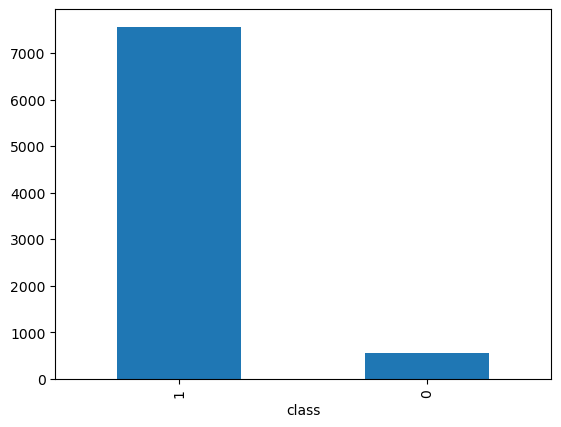

In [95]:
colum = df['class']
print(colum.shape)
pd.Series(colum).value_counts().plot.bar()